### Hedging with Real SPX Option Data

We implement and evaluate delta hedging strategeis for SPX index European call options using real market data. Create a standardized set of calibration and hedging metrics so that results that are comparable.

#### Dataset

The dataset consists of SPX call option quotes (WRDS export) over the period 2023-02-01 to 2023-02-28. For each trading date $t$ and each option contract (strike $K$, expiry $T$), the dataset contains at least

```
(date, exdate, symbol, strike price, best bid, best offer, impl volatility, delta, cp flag)
```

Use ```cp_flag = 'C'``` (calls only).

*NOTE:* Let $S_t$ denote the SPX close on date $t$. If $S_t$ is not included in the WRDS export, we must source it externally and merge it by date. 

Let $t$ index trading days. For any end-of-day quantity $X_t$ define

$$\Delta X_t := X_{t+1} - X_t$$

**Midquote:** Define the call option midquote by $V_t$ by:

$$V_t := \frac{\text{bid}_t + \text{ask}_t}{2} \quad \text{(use best bid/offer if available).}$$

**Maturity:** Define the days-to-expiration and year fraction:

$$D_t := (T - t) \text{ in days}, \quad \tau_t := \frac{D_t}{365}.$$

**Underlying:** Let $S_t$ denote the SPX close, with one-day change $$\Delta S_t := S_{t+1} - S_t$$

**Delta-hedge residual:** Given a delta hedge process $\delta t$ define the hedging residual:

$$\varepsilon_t(\delta) := \Delta V_t - \delta_t \Delta S_t.$$

**SSE and Gain:** For a set of observations $\mathcal{I}$, define:

$$\text{SSE}_{\mathcal{I}}(\delta) := \sum_{t \in \mathcal{I}} \varepsilon_t(\delta)^2.$$

Given two delta hedges, define the Gain:

$$\text{Gain}(A \text{ vs } B) := 1 - \frac{\text{SSE}(\delta^{(A)})}{\text{SSE}(\delta^{(B)})}$$

where both SSEs are computed over the same observation set.

*NOTE*: The competitive score will be based on SSE and Gain computed after the filtering and bucketing (Step 6).

#### Step 1: Data loading and cleaning

Load the option panel and apply the following preprocessing

- Keep calls only
- Convert dates to consistent format
- Rescale striks if needed to sthat strikes are in index-point units
- Construct the midquote $V_t$
- Remove observations with missing or invalid implied volatility

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw data
raw = pd.read_csv("data/option20230201_20230228.csv")
print(f"Raw rows: {len(raw)}")

# Filter to calls only
df = raw[raw["cp_flag"] == "C"].copy()
print(f"Rows after filtering to calls: {len(df)}")

# Convert dates
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Rescale strikes (WRDS stores strike × 1000)
df["strike_price"] = df["strike_price"] / 1000

# Construct midquote
df["Vt"] = (df["best_bid"] + df["best_offer"]) / 2

# Remove zero-midquote rows (bid=0 and ask=0)
before_zero = len(df)
df = df[df["Vt"] > 0]
print(f"Dropped {before_zero - len(df)} zero-midquote rows, remaining: {len(df)}")

# Remove missing/invalid implied volatility
before_iv = len(df)
df = df[df["impl_volatility"].notna() & (df["impl_volatility"] > 0)]
print(f"Dropped {before_iv - len(df)} missing/invalid IV rows, remaining: {len(df)}")

Raw rows: 175301
Rows after filtering to calls: 175301
Dropped 0 zero-midquote rows, remaining: 175301
Dropped 21573 missing/invalid IV rows, remaining: 153728


**Required Reporting:**

- Row counts before/after filtering to calls
- Number of unique trading dates and unique expiries
- Missing rates of ($V_t$, $\sigma_{mkt}$, $\delta$)
- The list of final columns kept for the project

In [8]:
# Required Reporting 

# Row counts before/after filtering
print("=" * 50)
print("Row Counts")
print(f"  Raw dataset:              {len(raw)}")
print(f"  After calls filter:       {len(raw[raw['cp_flag'] == 'C'])}")
print(f"  After zero-midquote drop: {before_zero - (before_zero - len(df) + (before_iv - len(df)))}")  
print(f"  After IV filter (final):  {len(df)}")

# Unique trading dates and expiries
print("\n" + "=" * 50)
print("Dates")
print(f"  Unique trading dates: {df['date'].nunique()}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Unique expiries:      {df['exdate'].nunique()}")

# Missing rates for key columns
print("\n" + "=" * 50)
print("Missing Rates (after cleaning)")
for col in ["Vt", "impl_volatility", "delta"]:
    miss = df[col].isna().sum()
    print(f"  {col:20s}: {miss}/{len(df)} ({100*miss/len(df):.2f}%)")

# Final columns to keep
keep_cols = [
    "date", "exdate", "symbol", "strike_price",
    "best_bid", "best_offer", "Vt",
    "impl_volatility", "delta", "cp_flag"
]
df = df[keep_cols]

print("\n" + "=" * 50)
print("Final Columns")
print(f"  {keep_cols}")
print(f"  Final shape: {df.shape}")

Row Counts
  Raw dataset:              175301
  After calls filter:       175301
  After zero-midquote drop: 132155
  After IV filter (final):  153728

Dates
  Unique trading dates: 19
  Date range: 2023-02-01 to 2023-02-28
  Unique expiries:      67

Missing Rates (after cleaning)
  Vt                  : 0/153728 (0.00%)
  impl_volatility     : 0/153728 (0.00%)
  delta               : 0/153728 (0.00%)

Final Columns
  ['date', 'exdate', 'symbol', 'strike_price', 'best_bid', 'best_offer', 'Vt', 'impl_volatility', 'delta', 'cp_flag']
  Final shape: (153728, 10)


#### Step 2: Constract time seriesa nd one-day option changes

Construct a contract identifier that tracks the same option over time (e.g. using ```symbol```). Within each contract, compute one-day changes

$$
\Delta V_t = V_{t+1} - V_t
$$

and keep only observations for which $\Delta V_t$ is defined.

In [9]:
df = df.sort_values(["symbol", "date"])
df["delta_Vt"] = df.groupby("symbol")["Vt"].diff(-1) * (-1)

trading_dates = sorted(df["date"].unique())
date_rank = {d: i for i, d in enumerate(trading_dates)}

df["date_rank"] = df["date"].map(date_rank)
df["next_date_rank"] = df.groupby("symbol")["date_rank"].shift(-1)  # <-- this was missing

df.loc[df["next_date_rank"] != df["date_rank"] + 1, "delta_Vt"] = np.nan  # <-- only this line, remove the pd.NaT one

df = df.drop(columns=["date_rank", "next_date_rank"])

before_delta = len(df)
df_step2 = df[df["delta_Vt"].notna()].copy()
print(f"Rows before Delta_Vt filter: {before_delta}")
print(f"Rows after Delta_Vt filter:  {len(df_step2)}")

Rows before Delta_Vt filter: 153728
Rows after Delta_Vt filter:  135386


**Required Reporting:**
- summary statistics of $V_t$ and and $\Delta V_t$
- number of contracts retained after constructing $\Delta V_t$

In [10]:
# Required Reporting
print("\n" + "-" * 50)
print("Vt")
print(df_step2["Vt"].describe().round(4))

print("\n" + "-" * 50)
print("Delta_Vt")
print(df_step2["delta_Vt"].describe().round(4))

print("\n" + "-" * 50)
n_contracts = df_step2["symbol"].nunique()
print(f"Number of unique contracts retained: {n_contracts}")


--------------------------------------------------
Vt
count    135386.0000
mean        399.3788
std         537.2200
min           0.0250
25%          31.8000
50%         187.1000
75%         559.1875
max        3945.6000
Name: Vt, dtype: float64

--------------------------------------------------
Delta_Vt
count    135386.0000
mean         -5.8744
std          25.7089
min        -119.3000
25%         -20.0500
50%          -2.0250
75%           4.4500
max          70.2000
Name: delta_Vt, dtype: float64

--------------------------------------------------
Number of unique contracts retained: 11004


#### Step 3: Underlying SPX merge and one-day underlying changes

Obtain the SPX close series ${S_t}$ over the full sample and compute:

$$
\Delta S_t = S_{t+1} - S_t
$$

Merge $S_t$ and $\Delta S_t$ into the option panel by date.

In [11]:
# Download SPX close via yfinance 
# end is exclusive in yfinance, so we use 2023-03-03 to include 2023-03-02
spx = yf.download("^GSPC", start="2023-02-01", end="2023-03-03")[["Close"]]
spx.columns = spx.columns.droplevel(1)
spx = spx.rename(columns={"Close": "St"})
spx.index = pd.to_datetime(spx.index)

[*********************100%***********************]  1 of 1 completed


In [12]:
# Compute Delta_St = S(t+1) - S(t)
spx["delta_St"] = spx["St"].shift(-1) - spx["St"]
print(spx.head())

Price                St   delta_St
Date                              
2023-02-01  4119.209961  60.549805
2023-02-02  4179.759766 -43.279785
2023-02-03  4136.479980 -25.399902
2023-02-06  4111.080078  52.919922
2023-02-07  4164.000000 -46.140137


In [13]:
# Merge into option panel by date 
df_step2 = df_step2.merge(spx, left_on="date", right_index=True, how="left")

**Required Reporting:**
- Merge coverage: % of the option observations matched to valid ($S_t, \Delta S_t$)
- Summary statistics of $S_t$ and $\Delta S_t$
- One plot of $S_t$ and one plot of $\Delta S_t$ over time

In [14]:
# Required Reporting
matched = df_step2["St"].notna().sum()
print(f"\nMerge coverage: {matched}/{len(df_step2)} ({100*matched/len(df_step2):.1f}%)")

print("\n" + "=" * 50)
print("St")
print(df_step2["St"].describe().round(2))

print("\n" + "=" * 50)
print("Delta_St")
print(df_step2["delta_St"].describe().round(2))


Merge coverage: 135386/135386 (100.0%)

St
count    135386.00
mean       4084.76
std          65.18
min        3970.04
25%        4012.32
50%        4090.46
75%        4136.48
max        4179.76
Name: St, dtype: float64

Delta_St
count    135386.00
mean         -8.88
std          37.86
min         -81.75
25%         -42.28
50%         -11.32
75%          12.20
max          60.55
Name: delta_St, dtype: float64


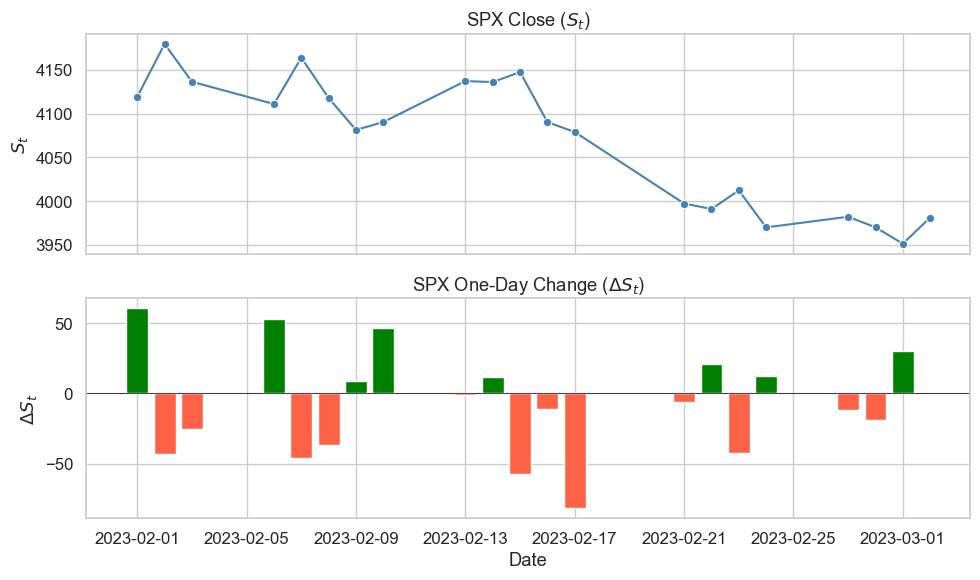

In [15]:
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot St
sns.lineplot(x=spx.index, y=spx["St"], ax=ax1, marker="o", color="steelblue", linewidth=1.5)
ax1.set_title("SPX Close ($S_t$)")
ax1.set_ylabel("$S_t$")

# Plot ΔSt
delta = spx["delta_St"].dropna()
colors = ["green" if v >= 0 else "tomato" for v in delta]
ax2.bar(delta.index, delta.values, color=colors, width=0.8)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_title("SPX One-Day Change ($\\Delta S_t$)")
ax2.set_ylabel("$\\Delta S_t$")
ax2.set_xlabel("Date")

fig.tight_layout()
plt.show()

#### Step 4: Stripping a daily risk-free curve with NSS model and extracting $r_t(\tau)$

For every trading date $t$, construct a smooth risk-free zero-rate curve and then evaluate it at each option maturity $\tau$ in your panel. The output is a continuously compounded zero rate $r_t(\tau)$ that will be used consistenlty in

- discounting: $e^{-r_t(\tau) \tau}$
- forward mapping: $F_t(\tau) = S_t e^{(r_t(\tau) - q) \tau}$



**Data Source US Treasury par yields):**

Let $y_t(m)$ denote the observed US Treasury par yield on date $t$ for a given standard maturity $m$. We use the Daily Treasure Par Yield Curve archive.

In practice, yields are provided in annualized % units and must be converted to decimals.

In [16]:
import pandas as pd

url = (
    "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/"
    "daily-treasury-rate-archives/par-yield-curve-rates-2020-2023.csv"
)

treasury = pd.read_csv(url)
treasury["date"] = pd.to_datetime(treasury["date"]).dt.normalize()

In [17]:
print("Columns:", treasury.columns.tolist())
print("Shape:", treasury.shape)
print(treasury.head())

Columns: ['date', '1 mo', '2 mo', '3 mo', '4 mo', '6 mo', '1 yr', '2 yr', '3 yr', '5 yr', '7 yr', '10 yr', '20 yr', '30 yr']
Shape: (1001, 14)
        date  1 mo  2 mo  3 mo  4 mo  6 mo  1 yr  2 yr  3 yr  5 yr  7 yr  \
0 2020-01-02  1.53  1.55  1.54   NaN  1.57  1.56  1.58  1.59  1.67  1.79   
1 2020-01-03  1.52  1.55  1.52   NaN  1.55  1.55  1.53  1.54  1.59  1.71   
2 2020-01-06  1.54  1.54  1.56   NaN  1.56  1.54  1.54  1.56  1.61  1.72   
3 2020-01-07  1.52  1.53  1.54   NaN  1.56  1.53  1.54  1.55  1.62  1.74   
4 2020-01-08  1.50  1.53  1.54   NaN  1.56  1.55  1.58  1.61  1.67  1.78   

   10 yr  20 yr  30 yr  
0   1.88   2.19   2.33  
1   1.80   2.11   2.26  
2   1.81   2.13   2.28  
3   1.83   2.16   2.31  
4   1.87   2.21   2.35  


**Objective:** For each option observation $(t, K, T)$ with year-fraction maturity $\tau = (T - t)/365$, we want to attach a risk-free rate $r_t(\tau)$.

To obtain the risk-free rate we do the following:

- align the Treasury curve to fit the option trading curves
- fit an NSS parametric yield curve for each date
- evaluate the fitted curve at option maturity $\tau$
- convert the resulting annual yield quote into a continuously compounding zero rate.

#### (a) Data alignment and missing-day handling

Let $\mathcal{T}^{\text{opt}}$ be the set of option trading dates in the panel. Construct a treasury yield panel indexied by  $\mathcal{T}^{\text{opt}}$ by forward-filling missing treasury observations:

$$
y_t(m) \leftarrow y_{\max \{s \leq t: s \in \mathcal{T}^{\text{tr}}\}}(m), \quad t \in \mathcal{T}^{\text{opt}},
$$

where $\mathcal{T}^{\text{tr}}$ the dates available in the Treasury file. This ensures that every option date has a full set of yields.

In [18]:
tenor_map = {
    "1 mo": 1/12,
    "2 mo": 2/12,
    "3 mo": 3/12,
    "4 mo": 4/12,
    "6 mo": 6/12,
    "1 yr": 1,
    "2 yr": 2,
    "3 yr": 3,
    "5 yr": 5,
    "7 yr": 7,
    "10 yr": 10,
    "20 yr": 20,
    "30 yr": 30,
}

# Convert yields from % to decimals 
yield_cols = list(tenor_map.keys())
treasury[yield_cols] = treasury[yield_cols] / 100

# Filter treasury to cover option dates (with some buffer before)
treasury = treasury[treasury["date"] >= "2023-01-15"].copy()
treasury = treasury.sort_values("date").set_index("date")

# Get option trading dates
option_dates = sorted(df_step2["date"].unique())
print(f"Option trading dates: {len(option_dates)}")
print(f"First: {option_dates[0].date()}, Last: {option_dates[-1].date()}")

# Reindex treasury to option dates, forward-filling gaps
all_dates = treasury.index.union(option_dates)
treasury = treasury.reindex(all_dates).ffill()

# Keep only option trading dates
treasury_aligned = treasury.loc[option_dates].copy()

print(f"\nAligned treasury shape: {treasury_aligned.shape}")
print(f"NaN count per tenor:\n{treasury_aligned[yield_cols].isna().sum()}")
print(f"\nSample (first 3 dates):")
print(treasury_aligned.head(3).round(5))

Option trading dates: 18
First: 2023-02-01, Last: 2023-02-27

Aligned treasury shape: (18, 13)
NaN count per tenor:
1 mo     0
2 mo     0
3 mo     0
4 mo     0
6 mo     0
1 yr     0
2 yr     0
3 yr     0
5 yr     0
7 yr     0
10 yr    0
20 yr    0
30 yr    0
dtype: int64

Sample (first 3 dates):
              1 mo    2 mo    3 mo    4 mo    6 mo    1 yr    2 yr    3 yr  \
date                                                                         
2023-02-01  0.0459  0.0463  0.0466  0.0477  0.0479  0.0466  0.0409  0.0375   
2023-02-02  0.0462  0.0465  0.0466  0.0475  0.0476  0.0464  0.0409  0.0375   
2023-02-03  0.0461  0.0467  0.0470  0.0480  0.0482  0.0479  0.0430  0.0396   

              5 yr    7 yr   10 yr   20 yr   30 yr  
date                                                
2023-02-01  0.0348  0.0343  0.0339  0.0367  0.0355  
2023-02-02  0.0349  0.0344  0.0340  0.0367  0.0355  
2023-02-03  0.0367  0.0361  0.0353  0.0377  0.0363  


#### (b) NSS curve

For each date $t$, fit a smooth parametric function $y_t(\tau)$ defined for any maturity $\tau > 0$:

$$
y_t(\tau) = \beta_{0,t} + \beta_{1,t} g_1(\tau; \tau_{1,t}) + \beta_{2,t} g_2(\tau; \tau_{1,t}) + \beta_{3,t} g_3(\tau; \tau_{2,t})
$$

where the basis functions are

$$
g_1(\tau; \lambda) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda}, 

g_2(\tau; \lambda) = g_1(\tau; \lambda) - e^{-\tau/\lambda}, 

g_3(\tau; \lambda) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}
$$

In [19]:
# Tenors in years (the observed maturities)
tenors = np.array([tenor_map[c] for c in yield_cols])

# NSS basis functions
def g1(tau, lam):
    x = tau / lam
    return (1 - np.exp(-x)) / x

def g2(tau, lam):
    return g1(tau, lam) - np.exp(-tau / lam)

def g3(tau, lam):
    return g1(tau, lam) - np.exp(-tau / lam)

# Full NSS yield curve
def nss_yield(tau, beta, tau1, tau2):
    """
    y(tau) = beta0 + beta1 * g1(tau; tau1) + beta2 * g2(tau; tau1) + beta3 * g3(tau; tau2)
    """
    return beta[0] + beta[1] * g1(tau, tau1) + beta[2] * g2(tau, tau1) + beta[3] * g3(tau, tau2)


#### (c) Daily calibration via grid search + conditional OLS

On each date $t$, we observe a discrete set of par yields
\begin{equation*}
    \{(m_j, y_t(m_j))\}_{j=1}^J, \quad J \approx 12.
\end{equation*}

For fixed $(\tau_1, \tau_2)$ the NSS model is \textbf{linear} in the $\beta$ coefficients. Define the regressor matrix
$$
    X(\tau_1, \tau_2) = \begin{pmatrix} 
    1 & g_1(m_1; \tau_1) & g_2(m_1; \tau_1) & g_3(m_1; \tau_2) \\ 
    \vdots & \vdots & \vdots & \vdots \\ 
    1 & g_1(m_J; \tau_1) & g_2(m_J; \tau_1) & g_3(m_J; \tau_2) 
    \end{pmatrix}, \quad 
    \mathbf{y}_t = \begin{pmatrix} 
    y_t(m_1) \\ 
    \vdots \\ 
    y_t(m_J) 
    \end{pmatrix}.
$$

Then the OLS estimate at $(\tau_1, \tau_2)$ is
$$
    \widehat{\beta}_t(\tau_1, \tau_2) = \arg \min_{\beta \in \mathbb{R}^4} \|\mathbf{y}_t - X(\tau_1, \tau_2)\beta\|_2^2 = (X^\top X)^{-1} X^\top \mathbf{y}_t.
$$

We select $(\tau_{1,t}, \tau_{2,t})$ by a grid search:
$$
    (\widehat{\tau}_{1,t}, \widehat{\tau}_{2,t}) = \arg \min_{(\tau_1, \tau_2) \in \mathcal{G}} \text{SSE}_t(\tau_1, \tau_2), \quad \text{SSE}_t(\tau_1, \tau_2) := \|\mathbf{y}_t - X(\tau_1, \tau_2)\widehat{\beta}_t(\tau_1, \tau_2)\|_2^2,
$$
with the constraint $\tau_2 \geq \tau_1$ for numerical stability. Finally, define the fitted daily curve
$$
    \widehat{y}_t(\tau) = y_t(\tau; \widehat{\beta}_t, \widehat{\tau}_{1,t}, \widehat{\tau}_{2,t}).
$$

In [ ]:
from numpy.linalg import lstsq

# Design matrix for OLS (linear in beta for fixed tau1, tau2)
def nss_design_matrix(tenors, tau1, tau2):
    X = np.column_stack([
        np.ones_like(tenors),
        g1(tenors, tau1),
        g2(tenors, tau1),
        g3(tenors, tau2),
    ])
    return X


def fit_nss(yields, tenors, tau1_grid, tau2_grid):
    best_sse = np.inf
    best_params = None
    
    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            if tau2 < tau1:
                continue
            X = nss_design_matrix(tenors, tau1, tau2)
            beta, _, _, _ = lstsq(X, yields, rcond=None)
            sse = np.sum((yields - X @ beta) ** 2)
            if sse < best_sse:
                best_sse = sse
                best_params = {"beta": beta, "tau1": tau1, "tau2": tau2, "sse": sse}
    
    return best_params


# Define grid
tau1_grid = np.arange(0.1, 5.1, 0.1)
tau2_grid = np.arange(0.1, 5.1, 0.1)

# Fit NSS for each trading date 
nss_results = {}
for date, row in treasury_aligned.iterrows():
    yields = row[yield_cols].values.astype(float)
    mask = ~np.isnan(yields)
    nss_results[date] = fit_nss(yields[mask], tenors[mask], tau1_grid, tau2_grid)

print(f"Fitted NSS for {len(nss_results)} dates")
for date in list(nss_results.keys())[:3]:
    r = nss_results[date]
    print(f"{date.date()}: tau1={r['tau1']:.1f}, tau2={r['tau2']:.1f}, SSE={r['sse']:.2e}, beta={np.round(r['beta'], 5)}")


Fitted NSS for 18 dates
2023-02-01: tau1=0.6, tau2=2.0, SSE=2.43e-06, beta=[ 0.03704  0.0073   0.03539 -0.02645]
2023-02-02: tau1=0.7, tau2=1.8, SSE=2.33e-06, beta=[ 0.03694  0.00812  0.0373  -0.03131]
2023-02-03: tau1=0.7, tau2=1.9, SSE=2.40e-06, beta=[ 0.03755  0.00724  0.03749 -0.02577]


#### (d) Evaluting the curve at option maturities

For each option row with maturity $\tau$, compute the annualized fitted yield \widehat{y}_t(\tau). To avoid ill-defined $\tau = 0$ limit in the basis functions and in discounting, apply a lower bound: 

$$
\tau \leftarrow \max\{\tau, 1/365\}.
$$

In [23]:
# Compute maturity τ for each option observation
df_step2["tau"] = (df_step2["exdate"] - df_step2["date"]).dt.days / 365

# Apply lower bound
df_step2["tau"] = df_step2["tau"].clip(lower=1/365)

# Evaluate NSS fitted yield at each option's maturity
def get_nss_yield(row, nss_results):
    r = nss_results[row["date"]]
    tau = np.array([row["tau"]])
    return nss_yield(tau, r["beta"], r["tau1"], r["tau2"])[0]

df_step2["y_fitted"] = df_step2.apply(get_nss_yield, axis=1, nss_results=nss_results)

print(f"Fitted yield (y) summary:")
print(df_step2["y_fitted"].describe().round(6))

Fitted yield (y) summary:
count    135386.000000
mean          0.047355
std           0.001969
min           0.034691
25%           0.046006
50%           0.047298
75%           0.048772
max           0.051517
Name: y_fitted, dtype: float64


#### (e) Converting treasury yeild quotes to a continuously-compounded zero rate.

Treasury par yields are quoted using semiannual compounding. Therefore continuously zero rate is defined by:

$$
r_t(\tau) = 2 \ln \left( 1 + \frac{\widehat{y}_t(\tau)}{2} \right)
$$

**Discount factor and forward:** Once $r_t(\tau)$ is available for each option observation:

$$
P_t(\tau) = e^{-r_t(\tau)\tau}, \qquad F_t(\tau) = S_t e^{(r_t(\tau)-q)\tau},
$$

where in this lab we set $q = 0$.

In [24]:
def to_continuous_rate(y):
    return 2 * np.log(1 + y / 2)

df_step2["rt"] = 2 * np.log(1 + df_step2["y_fitted"] / 2)

# Calculate discount factor P(t) and forward price F(t)
df_step2["Pt"] = np.exp(-df_step2["rt"] * df_step2["tau"])
df_step2["Ft"] = df_step2["St"] * np.exp(df_step2["rt"] * df_step2["tau"])

**Required Reporting:**

- a table/summary of ${r_t(\tau)}$ values (min/median/max) across the option panel
- one plot of the fitted curve $\tau \rightarrow r_t(\tau)$ for a representative date
- verification that every option has a finite $r_t(\tau)$ and discount factor $P_t(\tau)$

In [28]:
# 1. Summary of rt values
print("Summary of r_t")
print(f"  Min:    {df_step2['rt'].min():.6f}")
print(f"  Median: {df_step2['rt'].median():.6f}")
print(f"  Max:    {df_step2['rt'].max():.6f}")
print(f"  Mean:   {df_step2['rt'].mean():.6f}")
print(f"  Std:    {df_step2['rt'].std():.6f}")

# Verification: every row has finite rt and Pt
rt_finite = np.isfinite(df_step2["rt"]).all()
pt_finite = np.isfinite(df_step2["Pt"]).all()
print("\n" + "-" * 50)
print("Verification")
print(f"  All r_t finite:  {rt_finite}")
print(f"  All P_t finite:  {pt_finite}")
print(f"  Any rt NaN:        {df_step2['rt'].isna().sum()}")
print(f"  Any Pt NaN:        {df_step2['Pt'].isna().sum()}")

Summary of r_t
  Min:    0.034393
  Median: 0.046747
  Max:    0.050865
  Mean:   0.046802
  Std:    0.001924

--------------------------------------------------
Verification
  All r_t finite:  True
  All P_t finite:  True
  Any rt NaN:        0
  Any Pt NaN:        0


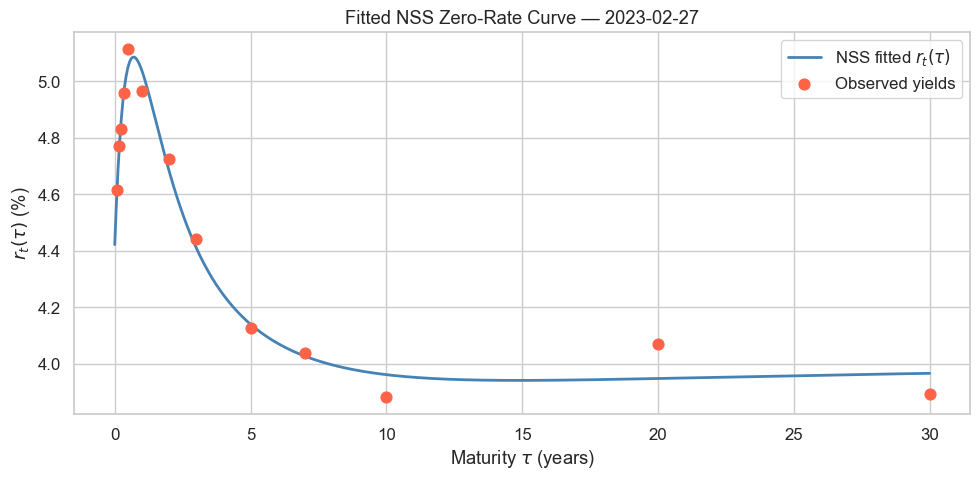

In [30]:
# Plot fitted curve for a representative date
rep_date = pd.Timestamp("2023-02-28")
if rep_date not in nss_results:
    rep_date = max(d for d in nss_results.keys() if d <= rep_date)
    
sns.set_theme(style="whitegrid", font_scale=1.1)
    
r = nss_results[rep_date]
tau_plot = np.linspace(1/365, 30, 500)
y_plot = nss_yield(tau_plot, r["beta"], r["tau1"], r["tau2"])
r_plot = 2 * np.log(1 + y_plot / 2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tau_plot, r_plot * 100, color="steelblue", linewidth=2, label="NSS fitted $r_t(\\tau)$")

# Overlay observed par yields (converted)
obs_yields = treasury_aligned.loc[rep_date, yield_cols].values.astype(float)
obs_r = 2 * np.log(1 + obs_yields / 2)
ax.scatter(tenors, obs_r * 100, color="tomato", zorder=5, s=60, label="Observed yields")

ax.set_xlabel("Maturity $\\tau$ (years)")
ax.set_ylabel("$r_t(\\tau)$ (%)")
ax.set_title(f"Fitted NSS Zero-Rate Curve — {rep_date.date()}")
ax.legend()
fig.tight_layout()
plt.show()

#### Step 5: BS delta hedging and hedging performance

This step establishes the baseline hedge performance.

**(a) Baseline delta:** If a dataset-provided hedge delta is available, use it as a baseline

$$
\Delta_t^{\text{BS}} := \delta_t^{\text{vendor}}
$$

**(b) Baseline residuals and SSE:** Compute residuals

$$
    \varepsilon_t(\Delta^{\text{BS}}) = \Delta V_t - \Delta_t^{\text{BS}} \Delta S_t,
$$

and the corresponding sum of squared erros (SSE) is:

$$
\text{SSE}(\Delta^{\text{BS}}) = \sum_{t} \varepsilon_t(\Delta^{\text{BS}})^2.
$$

**(c) Standardized filters**: After computing deltas, filter out observations observations with:

$$
\Delta_t^{\text{BS}} \leq 0.05, \quad \Delta_t^{\text{BS}} \geq 0.95, \quad D_t \leq 14.
$$

Filtering out options with extreme delta values and maturity less than 14 days will help with the analysis of the results. Report the remaining row count after each filter.

**(d) Standardized bucketing:** Create
- 9 moneyness buckets based on $\Delta_t^{\text{BS}}$ using equal-width bins over $(0.05, 0.95)$
- 7 maturity buckets based on $D_t$ using equal-width bins ober the filtered maturity range.

**(e) Hedging residuals and SSEs:** Compute the residuals

$$\varepsilon_t(\Delta_t^{\text{BS}}) := \Delta V_t - \Delta_t^{\text{BS}} \Delta S_t$$

and compute the total SSEs and MSE on the final filtered sample:

$$
\Delta_t^{\text{BS}} \leq 0.05, \quad \Delta_t^{\text{BS}} \geq 0.95, \quad D_t \leq 14.
$$

**Required reporting:**
- summary statistics of $\varepsilon_t(\Delta^{\text{BS}})$
- baseline $\text{SSE}(\Delta^{\text{BS}})$ after filters
- Study the misspecification effect on the hedging performance for the implied-volatility parameter. Select a grid of implied volatility parameters and hedge the option with different levels of implied-vol $\Delta_t^{\text{BS}}(\sigma)$. Connect the results to the theoretical result obtained in Exercise 2.


**Required plots:**
- Smile plots: $\sigma_{mkt}(K)$ for one chosen $(t, D)$. 
- Delta plots: $K \rightarrow \Delta_t^{\text{BS}}(K)$ for one chosen $(t, D)$.
- Heatmaps of $\text{SSE}_{i,j}(BS)$ and $\text{MSE}_{i,j}(BS)$ across the bucketing constructed.

#### Step 6: Standardized outputs for competitions
To participate in the ranking we must export ```HedgingScoreboard.csv``` containing:
    - total SSEs and MSE across the grid
    - bucketed results in tidy long format

**Submission:** Upload notebook, the two CSV files, and a short PDF report containing the required plots and short explanations.